# Plot model diagram

In [1]:
from augur.titer_model import TiterCollection
from augur.utils import json_to_tree
import datetime
import json
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from treetime.utils import numeric_date

%matplotlib inline

In [2]:
np.random.seed(314159)

In [3]:
sns.set_style("ticks")
plt.style.use("huddlej")

In [4]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 14
mpl.rc('text', usetex=False)
#mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [5]:
tip_size = 10
end_date = 2004.3

In [6]:
def float_to_datestring(time):
    """Convert a floating point date from TreeTime `numeric_date` to a date string
    """
    # Extract the year and remainder from the floating point date.
    year = int(time)
    remainder = time - year

    # Calculate the day of the year (out of 365 + 0.25 for leap years).
    tm_yday = int(remainder * 365.25)
    if tm_yday == 0:
        tm_yday = 1

    # Construct a date object from the year and day of the year.
    date = datetime.datetime.strptime("%s-%s" % (year, tm_yday), "%Y-%j")

    # Build the date string with zero-padded months and days.
    date_string = "%s-%.2i-%.2i" % (date.year, date.month, date.day)

    return date_string

In [104]:
def plot_tree_by_datetime(tree, color_by_trait=None, size_by_trait=None, initial_branch_width=5, tip_size=10,
              start_date=None, end_date=None, include_color_bar=False, ax=None, colorbar_ax=None,
              earliest_node_date=None, default_color="#cccccc", default_color_branch="#cccccc", override_y_values=None,
              cmap=None, default_size=0.001, plot_projection_from_date=None, plot_projection_to_date=None,
              projection_attr="projected_frequency"):
    """Plot a BioPython Phylo tree in the BALTIC-style.
    """
    # Plot H3N2 tree in BALTIC style from Bio.Phylo tree.
    if override_y_values is None:
        override_y_values = {}
        
    yvalues = [node.yvalue for node in tree.find_clades()]
    y_span = max(yvalues)
    y_unit = y_span / float(len(yvalues))

    # Setup colors.
    if color_by_trait:
        trait_name = color_by_trait
        
        if cmap is None:
            traits = [k.attr[trait_name] for k in tree.find_clades() if trait_name in k.attr]
            norm = mpl.colors.Normalize(min(traits), max(traits))
            cmap = mpl.cm.viridis

    #
    # Setup the figure grid.
    #

    if ax is None:
        if include_color_bar:
            fig = plt.figure(figsize=(8, 6), facecolor='w')
            gs = gridspec.GridSpec(2, 1, height_ratios=[14, 1], width_ratios=[1], hspace=0.1, wspace=0.1)
            ax = fig.add_subplot(gs[0])
            colorbar_ax = fig.add_subplot(gs[1])
        else:
            fig = plt.figure(figsize=(8, 4), facecolor='w')
            gs = gridspec.GridSpec(1, 1)
            ax = fig.add_subplot(gs[0])

    L=len([k for k in tree.find_clades() if k.is_terminal()])

    # Setup arrays for tip and internal node coordinates.
    tip_circles_x = []
    tip_circles_y = []
    tip_circles_color = []
    tip_circle_sizes = []
    node_circles_x = []
    node_circles_y = []
    node_circles_color = []
    node_line_widths = []
    node_line_segments = []
    node_line_colors = []
    branch_line_segments = []
    branch_line_widths = []
    branch_line_colors = []
    branch_line_labels = []
    projection_line_segments = []

    for k in tree.find_clades(): ## iterate over objects in tree
        x=k.attr["collection_date_ordinal"] ## or from x position determined earlier
        
        if earliest_node_date and x < earliest_node_date:
            continue
        
        if k.name in override_y_values:
            y = override_y_values[k.name]
        else:
            y = y_span - k.yvalue ## get y position from .drawTree that was run earlier, but could be anything else

        if k.parent is None:
            xp = None
        else:
            xp=k.parent.attr["collection_date_ordinal"] ## get x position of current object's parent

        #if x==None: ## matplotlib won't plot Nones, like root
        #    x=0.0
        if xp==None:
            xp=x

        c = default_color
        if color_by_trait and trait_name in k.attr:
            if isinstance(cmap, dict):
                c = cmap[k.attr[trait_name]]
            else:
                c = cmap(norm(k.attr[trait_name]))

        branchWidth=initial_branch_width
        if k.is_terminal(): ## if leaf...            
            if size_by_trait is not None and size_by_trait in k.attr:
                s = (1e6 * (k.attr.get(size_by_trait, default_size) ** 2))
            else:
                s = tip_size ## tip size can be fixed

            tip_circle_sizes.append(s)
            tip_circles_x.append(x)
            tip_circles_y.append(y)
            tip_circles_color.append(c)
            
            if plot_projection_to_date is not None and plot_projection_from_date is not None:
                if k.attr.get(projection_attr, 0.0) > 1e-4:
                    future_s = (1e6 * (k.attr.get(projection_attr) ** 2))
                    future_x = plot_projection_to_date + np.random.randint(-20, 20)
                    future_y = y
                    future_c = c

                    tip_circle_sizes.append(future_s)
                    tip_circles_x.append(future_x)
                    tip_circles_y.append(future_y)
                    tip_circles_color.append(future_c)
                    
                    projection_line_segments.append([(x + 1, y), (future_x, y)])
            
        else: ## if node...
            k_leaves = [child
                        for child in k.find_clades()
                        if child.is_terminal()]

            # Scale branch widths by the number of tips.
            branchWidth += initial_branch_width * len(k_leaves) / float(L)

            if len(k.clades)==1:
                node_circles_x.append(x)
                node_circles_y.append(y)
                node_circles_color.append(c)

            ax.plot([x,x],[y_span - k.clades[-1].yvalue, y_span - k.clades[0].yvalue], lw=branchWidth, color=default_color_branch, ls='-', zorder=9, solid_capstyle='round')

        branch_line_segments.append([(xp, y), (x, y)])
        branch_line_widths.append(branchWidth)
        branch_line_colors.append(default_color_branch)

    branch_lc = LineCollection(branch_line_segments, zorder=9)
    branch_lc.set_color(branch_line_colors)
    branch_lc.set_linewidth(branch_line_widths)
    branch_lc.set_label(branch_line_labels)
    branch_lc.set_linestyle("-")
    ax.add_collection(branch_lc)
    
    if len(projection_line_segments) > 0:
        projection_lc = LineCollection(projection_line_segments, zorder=-10)
        projection_lc.set_color("#cccccc")
        projection_lc.set_linewidth(1)
        projection_lc.set_linestyle("--")
        projection_lc.set_alpha(0.5)
        ax.add_collection(projection_lc)

    # Add circles for tips and internal nodes.
    tip_circle_sizes = np.array(tip_circle_sizes)
    ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes, facecolor=tip_circles_color, edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes*1.75, facecolor="#000000", edgecolor='none', zorder=10) ## plot black circle underneath
    ax.scatter(node_circles_x, node_circles_y, facecolor=node_circles_color, s=50, edgecolor='none', zorder=10, lw=2, marker='|') ## mark every node in the tree to highlight that it's a multitype tree

    #ax.set_ylim(-10, y_span - 300)

    ax.spines['top'].set_visible(False) ## no axes
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.tick_params(axis='y',size=0)
    ax.set_yticklabels([])

    if start_date:
        ax.set_xlim(left=start_date)

    if end_date:
        ax.set_xlim(right=end_date)

    if include_color_bar:
        cb1 = mpl.colorbar.ColorbarBase(
            colorbar_ax,
            cmap=cmap,
            norm=norm,
            orientation='horizontal'
        )
        cb1.set_label(color_by_trait)

    return ax, colorbar_ax

## Load trees

Load an auspice tree for both timepoint t and timepoint u. The first tree needs to be annotated with the projected frequency at time u and weighted distance to the future.

Both trees need to be annotated with amino acid sequences for the tips as an `aa_sequence` key in each tip's `attr` attribute.

In [8]:
with open("../results/auspice/flu_simulated_simulated_sample_3_2029-10-01_tree.json", "r") as fh:
    tree_json_for_t = json.load(fh)
    
tree_for_t = json_to_tree(tree_json_for_t)

In [9]:
tree_for_t

Clade(branch_length=0, clade=11378, name='NODE_0000002', numdate=2022.4324299059615, strain='NODE_0000002', yvalue=6387.832632121854)

In [10]:
latest_sample_date_in_t = max([node.attr["num_date"] for node in tree_for_t.find_clades(terminal=True)])

In [11]:
latest_sample_date_in_t

2029.74

In [12]:
earliest_date_to_plot = latest_sample_date_in_t - 2.0

In [13]:
with open("../results/auspice/flu_simulated_simulated_sample_3_2030-10-01_tree.json", "r") as fh:
    tree_json_for_u = json.load(fh)

In [14]:
tree_for_u = json_to_tree(tree_json_for_u)

In [15]:
tree_for_u

Clade(branch_length=0, clade=11429, name='NODE_0000004', numdate=2023.0047601300064, strain='NODE_0000004', yvalue=6379.074866694113)

Annotate ordinal collection dates from floating point dates on both trees.

In [16]:
for node in tree_for_t.find_clades():
    node.attr["collection_date_ordinal"] = pd.to_datetime(float_to_datestring(node.attr["num_date"])).toordinal()

In [17]:
for node in tree_for_u.find_clades():
    node.attr["collection_date_ordinal"] = pd.to_datetime(float_to_datestring(node.attr["num_date"])).toordinal()

## t-SNE to cluster sequences

Cluster sequences for tips in the latest tree which should be a super set of tips in the earliest tree. We only consider tips with a projected frequency greater than zero from timepoint t to u or tips that are collected after timepoint t. Clustering happens in one dimension through t-SNE dimensionality reduction. This is a simple way of identifying sequences that are "close" to each other in a low dimensional space for comparison of tips within and between timepoints.

In [18]:
projected_frequency_by_sample_from_t = {
    node.name: node.attr.get("projected_frequency", 0.0)
    for node in tree_for_t.find_clades(terminal=True)
}

In [19]:
#projected_frequency_by_sample_from_t.get(node.name, 0.0) > 0 or 

In [20]:
nodes = [
    node for node in tree_for_u.find_clades(terminal=True)
    if node.attr["num_date"] > earliest_date_to_plot
]

In [21]:
total_nodes = len(nodes)

In [22]:
total_nodes

3240

In [52]:
distances = np.zeros((total_nodes, total_nodes))
for i, node_a in enumerate(nodes):
    node_a_array = np.frombuffer(node_a.attr["aa_sequence"].encode(), 'S1')
    
    for j, node_b in enumerate(nodes):
        if node_a.name == node_b.name:
            distance = 0.0
        elif distances[j, i] > 0:
            distance = distances[j, i]
        else:
            node_b_array = np.frombuffer(node_b.attr["aa_sequence"].encode(), 'S1')
            distance = (node_a_array != node_b_array).sum()
            
        distances[i, j] = distance

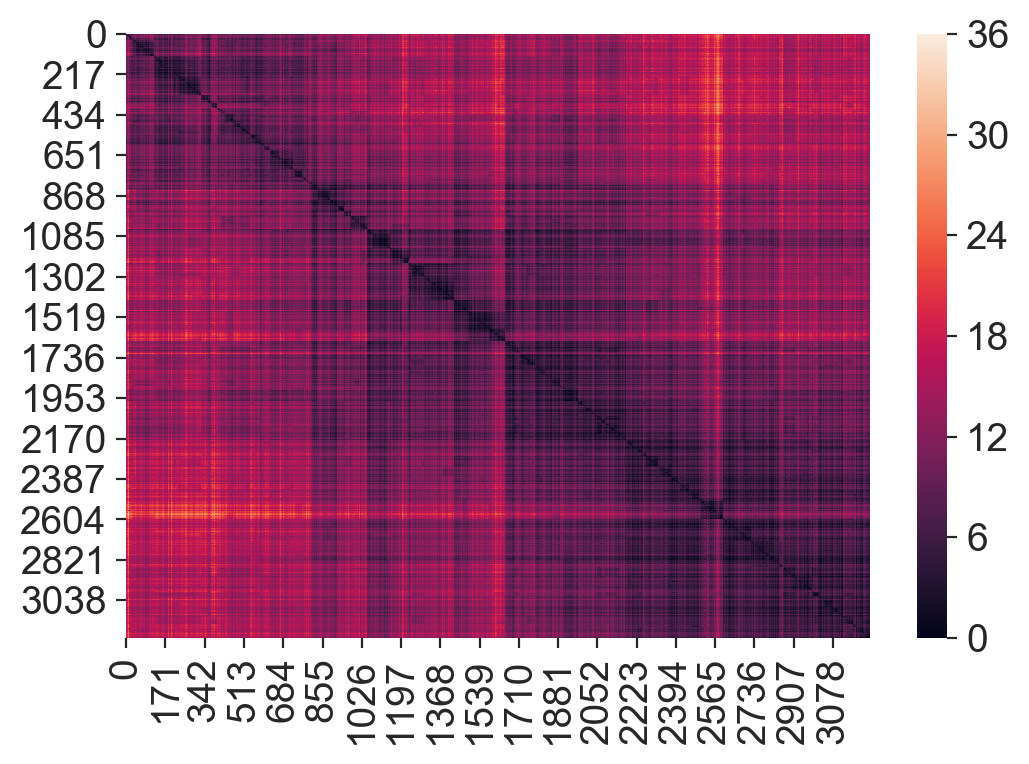

In [53]:
sns.heatmap(distances)

In [54]:
X_embedded_1d = TSNE(n_components=1, learning_rate=500).fit_transform(distances)

(-0.005, 0.005)

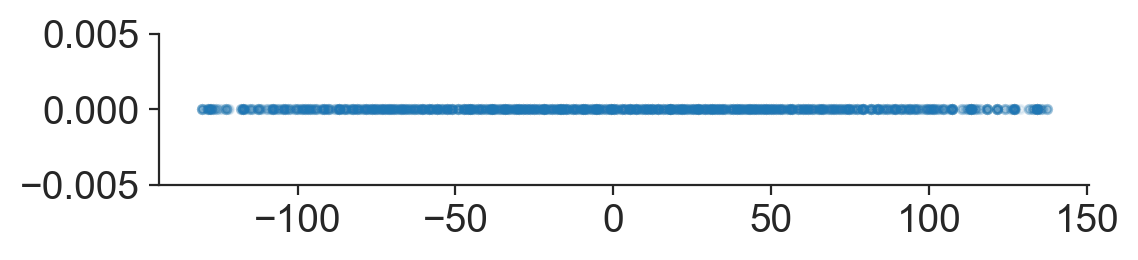

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(6, 1))
ax.plot(X_embedded_1d[:, 0], np.zeros_like(X_embedded_1d[:, 0]), ".", alpha=0.05)
ax.set_ylim(-0.005, 0.005)

Annotate nodes in both trees with ranks from t-SNE.

In [56]:
tree_t_nodes_by_name = {node.name: node for node in tree_for_t.find_clades(terminal=True)}

In [57]:
rank_records = []
for i, node in enumerate(nodes):
    node.attr["rank"] = X_embedded_1d[i, 0]
    
    if node.name in tree_t_nodes_by_name:
        tree_t_nodes_by_name[node.name].attr["rank"] = X_embedded_1d[i, 0]
    
    rank_records.append({
        "strain": node.name,
        "rank": node.attr["rank"]
    })

In [58]:
rank_df = pd.DataFrame(rank_records)

In [59]:
rank_normalizer = mpl.colors.Normalize(rank_df["rank"].min(), rank_df["rank"].max())

In [60]:
rank_df["color"] = rank_df["rank"].apply(rank_normalizer).apply(lambda value: mpl.cm.viridis(value))

In [61]:
rank_df.head()

,rank,strain,color
0,-69.361984,sample_5588_65,"(0.241237, 0.296485, 0.539709, 1.0)"
1,-69.323196,sample_5556_36,"(0.241237, 0.296485, 0.539709, 1.0)"
2,-69.332947,sample_5560_88,"(0.241237, 0.296485, 0.539709, 1.0)"
3,-64.624001,sample_5552_29,"(0.233603, 0.313828, 0.543914, 1.0)"
4,-67.087212,sample_5552_76,"(0.237441, 0.305202, 0.541921, 1.0)"


## Load frequencies

Load tip frequencies from auspice. These should include a `projected_pivot` key and one or more pivots after that timepoint for each tip.

In [24]:
with open("../results/auspice/flu_simulated_simulated_sample_3_2029-10-01_tip-frequencies.json", "r") as fh:
    frequencies_for_t = json.load(fh)

In [25]:
with open("../results/auspice/flu_simulated_simulated_sample_3_2030-10-01_tip-frequencies.json", "r") as fh:
    frequencies_for_u = json.load(fh)

In [26]:
pivots = frequencies_for_t.pop("pivots")

In [27]:
projection_pivot = frequencies_for_t.pop("projection_pivot")

In [28]:
pivots

[2023.75,
 2024.25,
 2024.75,
 2025.25,
 2025.75,
 2026.25,
 2026.75,
 2027.25,
 2027.75,
 2028.25,
 2028.75,
 2029.25,
 2029.75,
 2030.25,
 2030.75]

In [29]:
projection_pivot

2029.75

In [30]:
projection_pivot_index_for_t = pivots.index(projection_pivot)

In [31]:
projection_pivot_index_for_t

12

In [32]:
pivots[projection_pivot_index_for_t]

2029.75

In [33]:
frequency_records_for_t = []
for sample, sample_frequencies in frequencies_for_t.items():
    for pivot, sample_frequency in zip(pivots, sample_frequencies["frequencies"]):
        frequency_records_for_t.append({
            "strain": sample,
            "timepoint": float_to_datestring(pivot),
            "pivot": pivot,
            "frequency": sample_frequency
        })

In [34]:
frequency_df_for_t = pd.DataFrame(frequency_records_for_t)

In [35]:
frequency_df_for_t["timepoint"] = pd.to_datetime(frequency_df_for_t["timepoint"])

In [36]:
frequency_df_for_t.head()

,frequency,pivot,strain,timepoint
0,0.00433,2023.75,sample_4752_10,2023-09-30
1,0.00003,2024.25,sample_4752_10,2024-03-31
2,0.00000,2024.75,sample_4752_10,2024-09-29
3,0.00000,2025.25,sample_4752_10,2025-04-01
4,0.00000,2025.75,sample_4752_10,2025-09-30


Repeat the above analysis to get observed frequencies at timepoint u. We ignore all projected frequencies from this later timepoint, however.

In [37]:
pivots_for_u = frequencies_for_u.pop("pivots")

In [38]:
projection_pivot_for_u = frequencies_for_u.pop("projection_pivot")

In [39]:
projection_pivot_index = pivots_for_u.index(projection_pivot_for_u)

In [40]:
pivots_for_u[:projection_pivot_index + 1]

[2024.75,
 2025.25,
 2025.75,
 2026.25,
 2026.75,
 2027.25,
 2027.75,
 2028.25,
 2028.75,
 2029.25,
 2029.75,
 2030.25,
 2030.75]

In [41]:
frequency_records_for_u = []
for sample, sample_frequencies in frequencies_for_u.items():
    for pivot, sample_frequency in zip(pivots_for_u, sample_frequencies["frequencies"]):
        # Ignore projected frequencies from timepoint u.
        if pivot <= projection_pivot_for_u:
            frequency_records_for_u.append({
                "strain": sample,
                "timepoint": float_to_datestring(pivot),
                "pivot": pivot,
                "frequency": sample_frequency
            })

In [42]:
frequency_df_for_u = pd.DataFrame(frequency_records_for_u)

In [43]:
frequency_df_for_u["timepoint"] = pd.to_datetime(frequency_df_for_u["timepoint"])

In [44]:
frequency_df_for_u.head()

,frequency,pivot,strain,timepoint
0,0.004357,2024.75,sample_4952_12,2024-09-29
1,0.000029,2025.25,sample_4952_12,2025-04-01
2,0.000000,2025.75,sample_4952_12,2025-09-30
3,0.000000,2026.25,sample_4952_12,2026-04-01
4,0.000000,2026.75,sample_4952_12,2026-09-30


Annotate trees with frequencies at corresponding timepoints. For the tree at timepoint t, annotate both current and projected frequencies. For the tree at timepoint u, annotate the current frequencies.

In [45]:
pivots[projection_pivot_index_for_t]

2029.75

In [46]:
projection_pivot_index_for_t

12

In [93]:
max_frequency = 0.01

In [94]:
for tip in tree_for_t.find_clades(terminal=True):
    tip.attr["frequency_at_t"] = min(frequencies_for_t[tip.name]["frequencies"][projection_pivot_index_for_t], max_frequency)
    tip.attr["projected_frequency_at_u"] = min(frequencies_for_t[tip.name]["frequencies"][-1], max_frequency)

In [95]:
projection_pivot

2029.75

In [96]:
for tip in tree_for_u.find_clades(terminal=True):
    if tip.attr["num_date"] > projection_pivot:
        tip.attr["frequency_at_u"] = min(frequencies_for_u[tip.name]["frequencies"][projection_pivot_index], max_frequency)
    else:
        tip.attr["frequency_at_u"] = 0.0

Annotate t-SNE-based cluster information for both sets of frequencies.

In [62]:
rank_frequency_df_for_t = frequency_df_for_t.merge(
    rank_df,
    on="strain"
).sort_values(["rank", "strain", "timepoint"])

In [63]:
rank_frequency_df_for_t["ordinal_timepoint"] = rank_frequency_df_for_t["timepoint"].apply(lambda value: value.toordinal())

In [64]:
rank_frequency_df_for_u = frequency_df_for_u.merge(
    rank_df,
    on="strain"
).sort_values(["rank", "strain", "timepoint"])

In [65]:
rank_frequency_df_for_u["ordinal_timepoint"] = rank_frequency_df_for_u["timepoint"].apply(lambda value: value.toordinal())

In [66]:
rank_frequency_df_for_t.head()

,frequency,pivot,strain,timepoint,rank,color,ordinal_timepoint
5295,0.0,2023.75,sample_5616_70,2023-09-30,-117.896538,"(0.279566, 0.067836, 0.391917, 1.0)",738793
5296,0.0,2024.25,sample_5616_70,2024-03-31,-117.896538,"(0.279566, 0.067836, 0.391917, 1.0)",738976
5297,0.0,2024.75,sample_5616_70,2024-09-29,-117.896538,"(0.279566, 0.067836, 0.391917, 1.0)",739158
5298,0.0,2025.25,sample_5616_70,2025-04-01,-117.896538,"(0.279566, 0.067836, 0.391917, 1.0)",739342
5299,0.0,2025.75,sample_5616_70,2025-09-30,-117.896538,"(0.279566, 0.067836, 0.391917, 1.0)",739524


In [67]:
rank_frequency_df_for_u.head()

,frequency,pivot,strain,timepoint,rank,color,ordinal_timepoint
39780,0.0,2024.75,sample_6120_16,2024-09-29,-130.437057,"(0.267004, 0.004874, 0.329415, 1.0)",739158
39781,0.0,2025.25,sample_6120_16,2025-04-01,-130.437057,"(0.267004, 0.004874, 0.329415, 1.0)",739342
39782,0.0,2025.75,sample_6120_16,2025-09-30,-130.437057,"(0.267004, 0.004874, 0.329415, 1.0)",739524
39783,0.0,2026.25,sample_6120_16,2026-04-01,-130.437057,"(0.267004, 0.004874, 0.329415, 1.0)",739707
39784,0.0,2026.75,sample_6120_16,2026-09-30,-130.437057,"(0.267004, 0.004874, 0.329415, 1.0)",739889


In [68]:
start_date = pd.to_datetime("2028-10-01").toordinal()
end_date = pd.to_datetime("2030-11-01").toordinal()
timepoint_t = pd.to_datetime(float_to_datestring(projection_pivot)).toordinal()
timepoint_u = pd.to_datetime(float_to_datestring(projection_pivot_for_u)).toordinal()

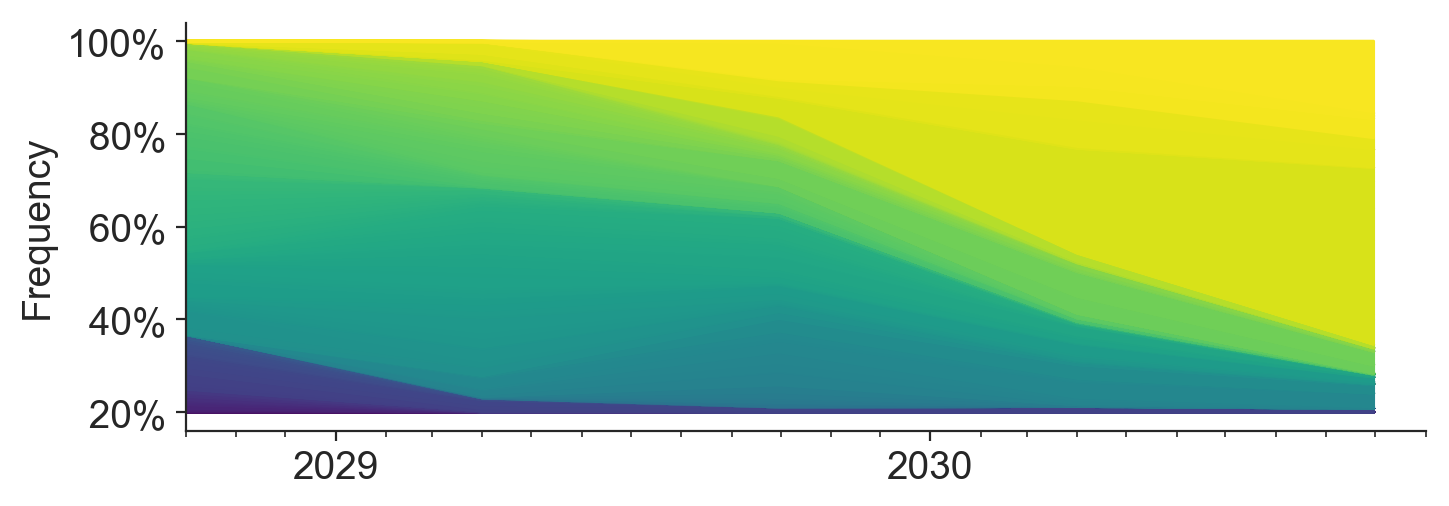

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
baseline = np.zeros_like(pivots)

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter("%Y")
months = mdates.MonthLocator()

for strain, strain_df in rank_frequency_df_for_t.groupby(["rank", "strain"]):
    ax.fill_between(strain_df["ordinal_timepoint"].values, baseline, baseline + strain_df["frequency"].values, color=strain_df["color"].unique()[0])
    baseline = baseline + strain_df["frequency"].values

ax.set_xlim(start_date, end_date)
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.format_xdata = mdates.DateFormatter("%b %Y")

ax.set_ylabel("Frequency")

fig.autofmt_xdate(rotation=0, ha="center")

## Plot tree

In [70]:
frequency_steps = [0, 0.25, 0.5, 0.75, 1.0]

In [71]:
for tip in tree_for_t.find_clades(terminal=True):
    if "projected_frequency" in tip.attr:
        if tip.attr["projected_frequency"] > 0.05:
            tip.attr["projected_frequency"] = 0.05
    else:
        tip.attr["projected_frequency"] = 0.0001

In [74]:
yvalues = [node.yvalue for node in tree_for_t.find_clades(terminal=True)]
y_span = max(yvalues)

In [75]:
y_span

6480

In [76]:
min(yvalues)

1

In [101]:
max([node.attr["frequency_at_t"] for node in tree_for_t.find_clades(terminal=True)])

0.004415

In [99]:
max([node.attr["projected_frequency_at_u"] for node in tree_for_t.find_clades(terminal=True)])

0.01

In [100]:
max([node.attr["frequency_at_u"] for node in tree_for_u.find_clades(terminal=True)])

0.004441

(3500, 6600)

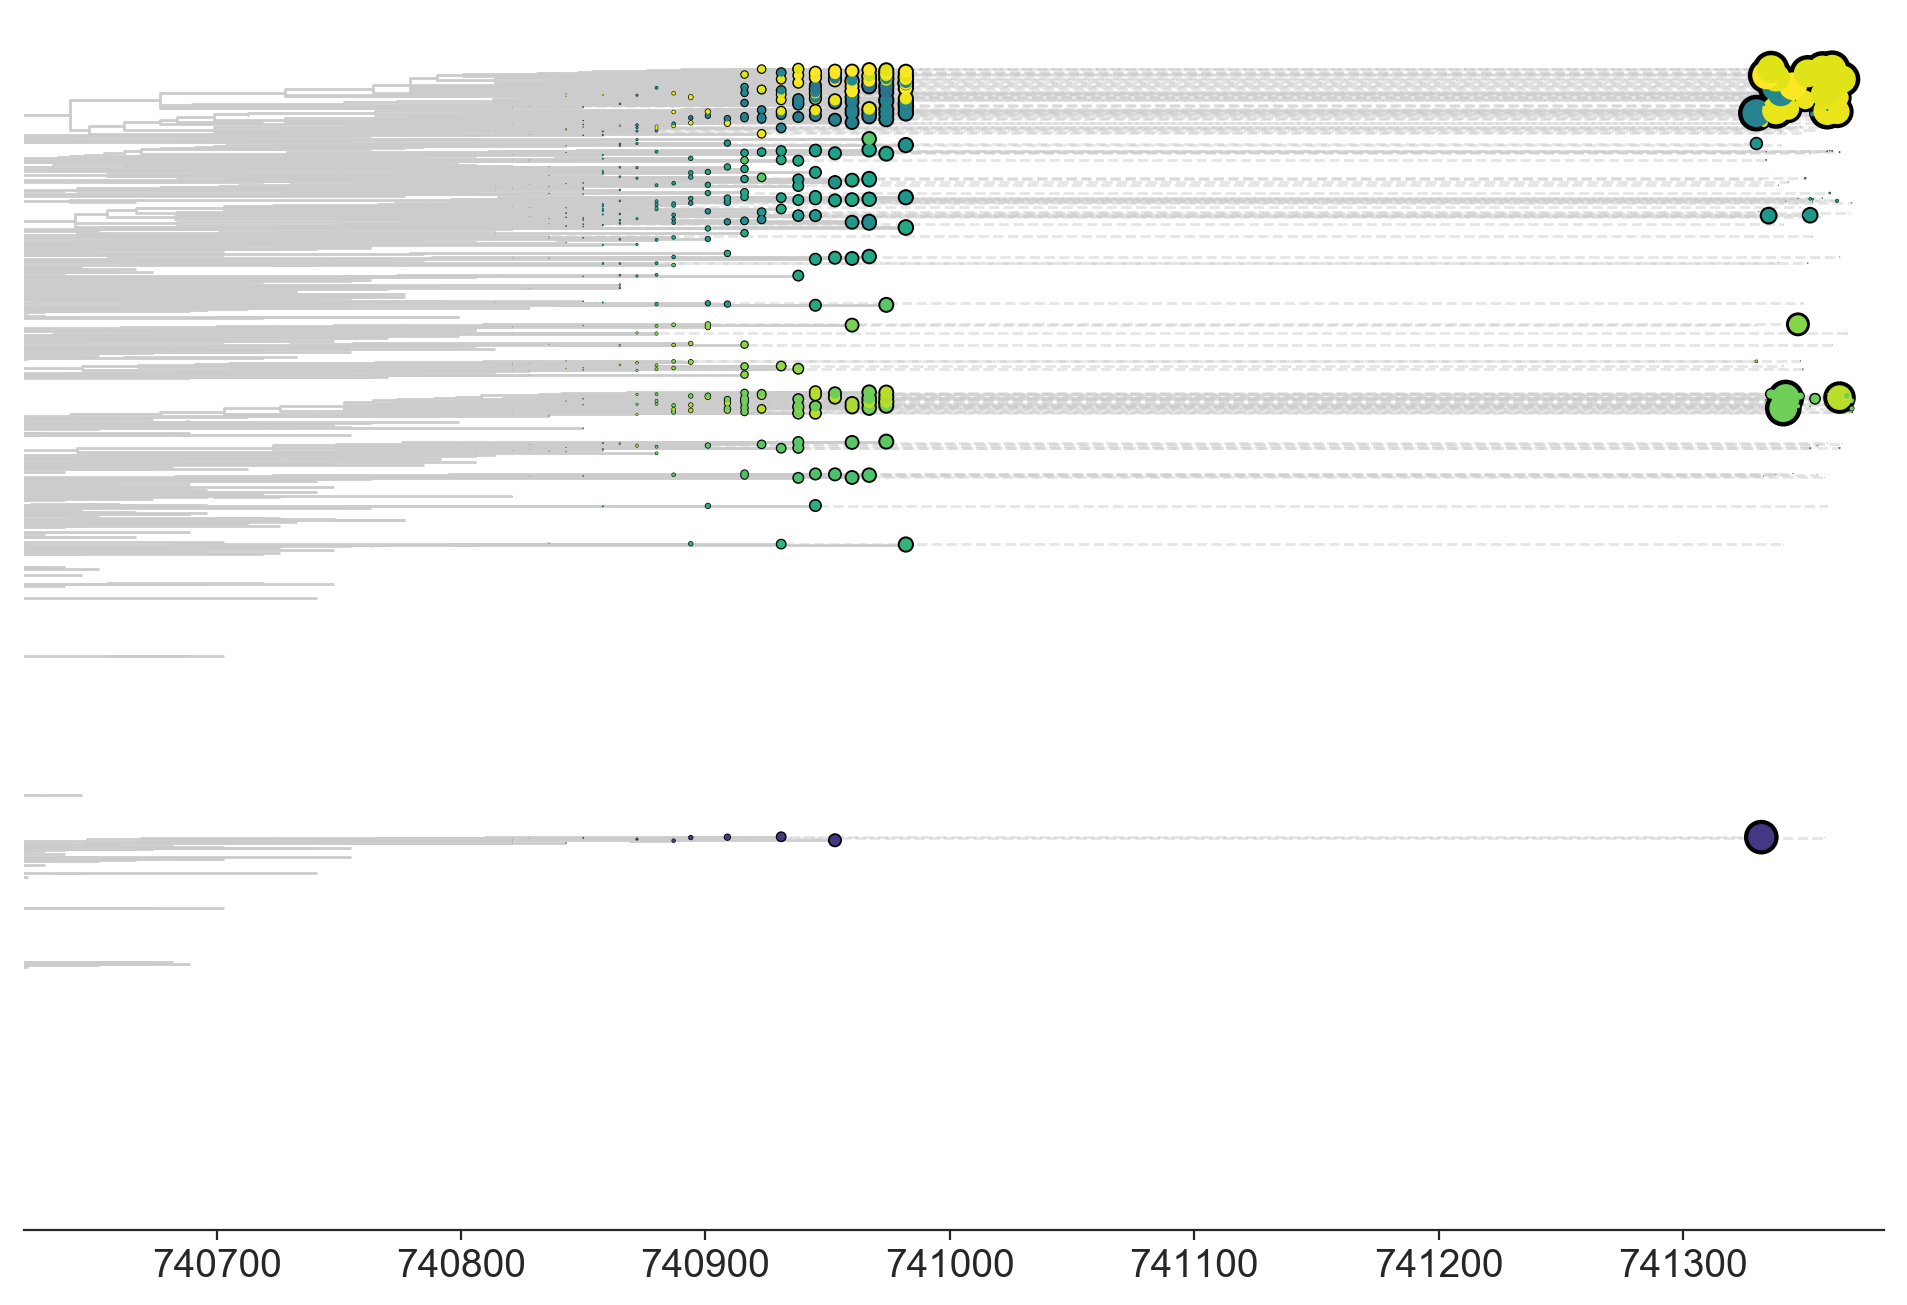

In [105]:
fig = plt.figure(figsize=(12, 8), facecolor='w')
gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.25, wspace=0.1)

# Tree plot for timepoint t

tree_ax = fig.add_subplot(gs[0])    
tree_ax, colorbar_ax = plot_tree_by_datetime(
    tree_for_t,
    color_by_trait="rank",
    size_by_trait="frequency_at_t",
    ax=tree_ax,
    start_date=start_date,
    end_date=end_date,
    tip_size=tip_size,
    initial_branch_width=1,
    plot_projection_from_date=timepoint_t,
    plot_projection_to_date=timepoint_u,
    projection_attr="projected_frequency_at_u"
)
tree_ax.set_ylim(3500, 6600)

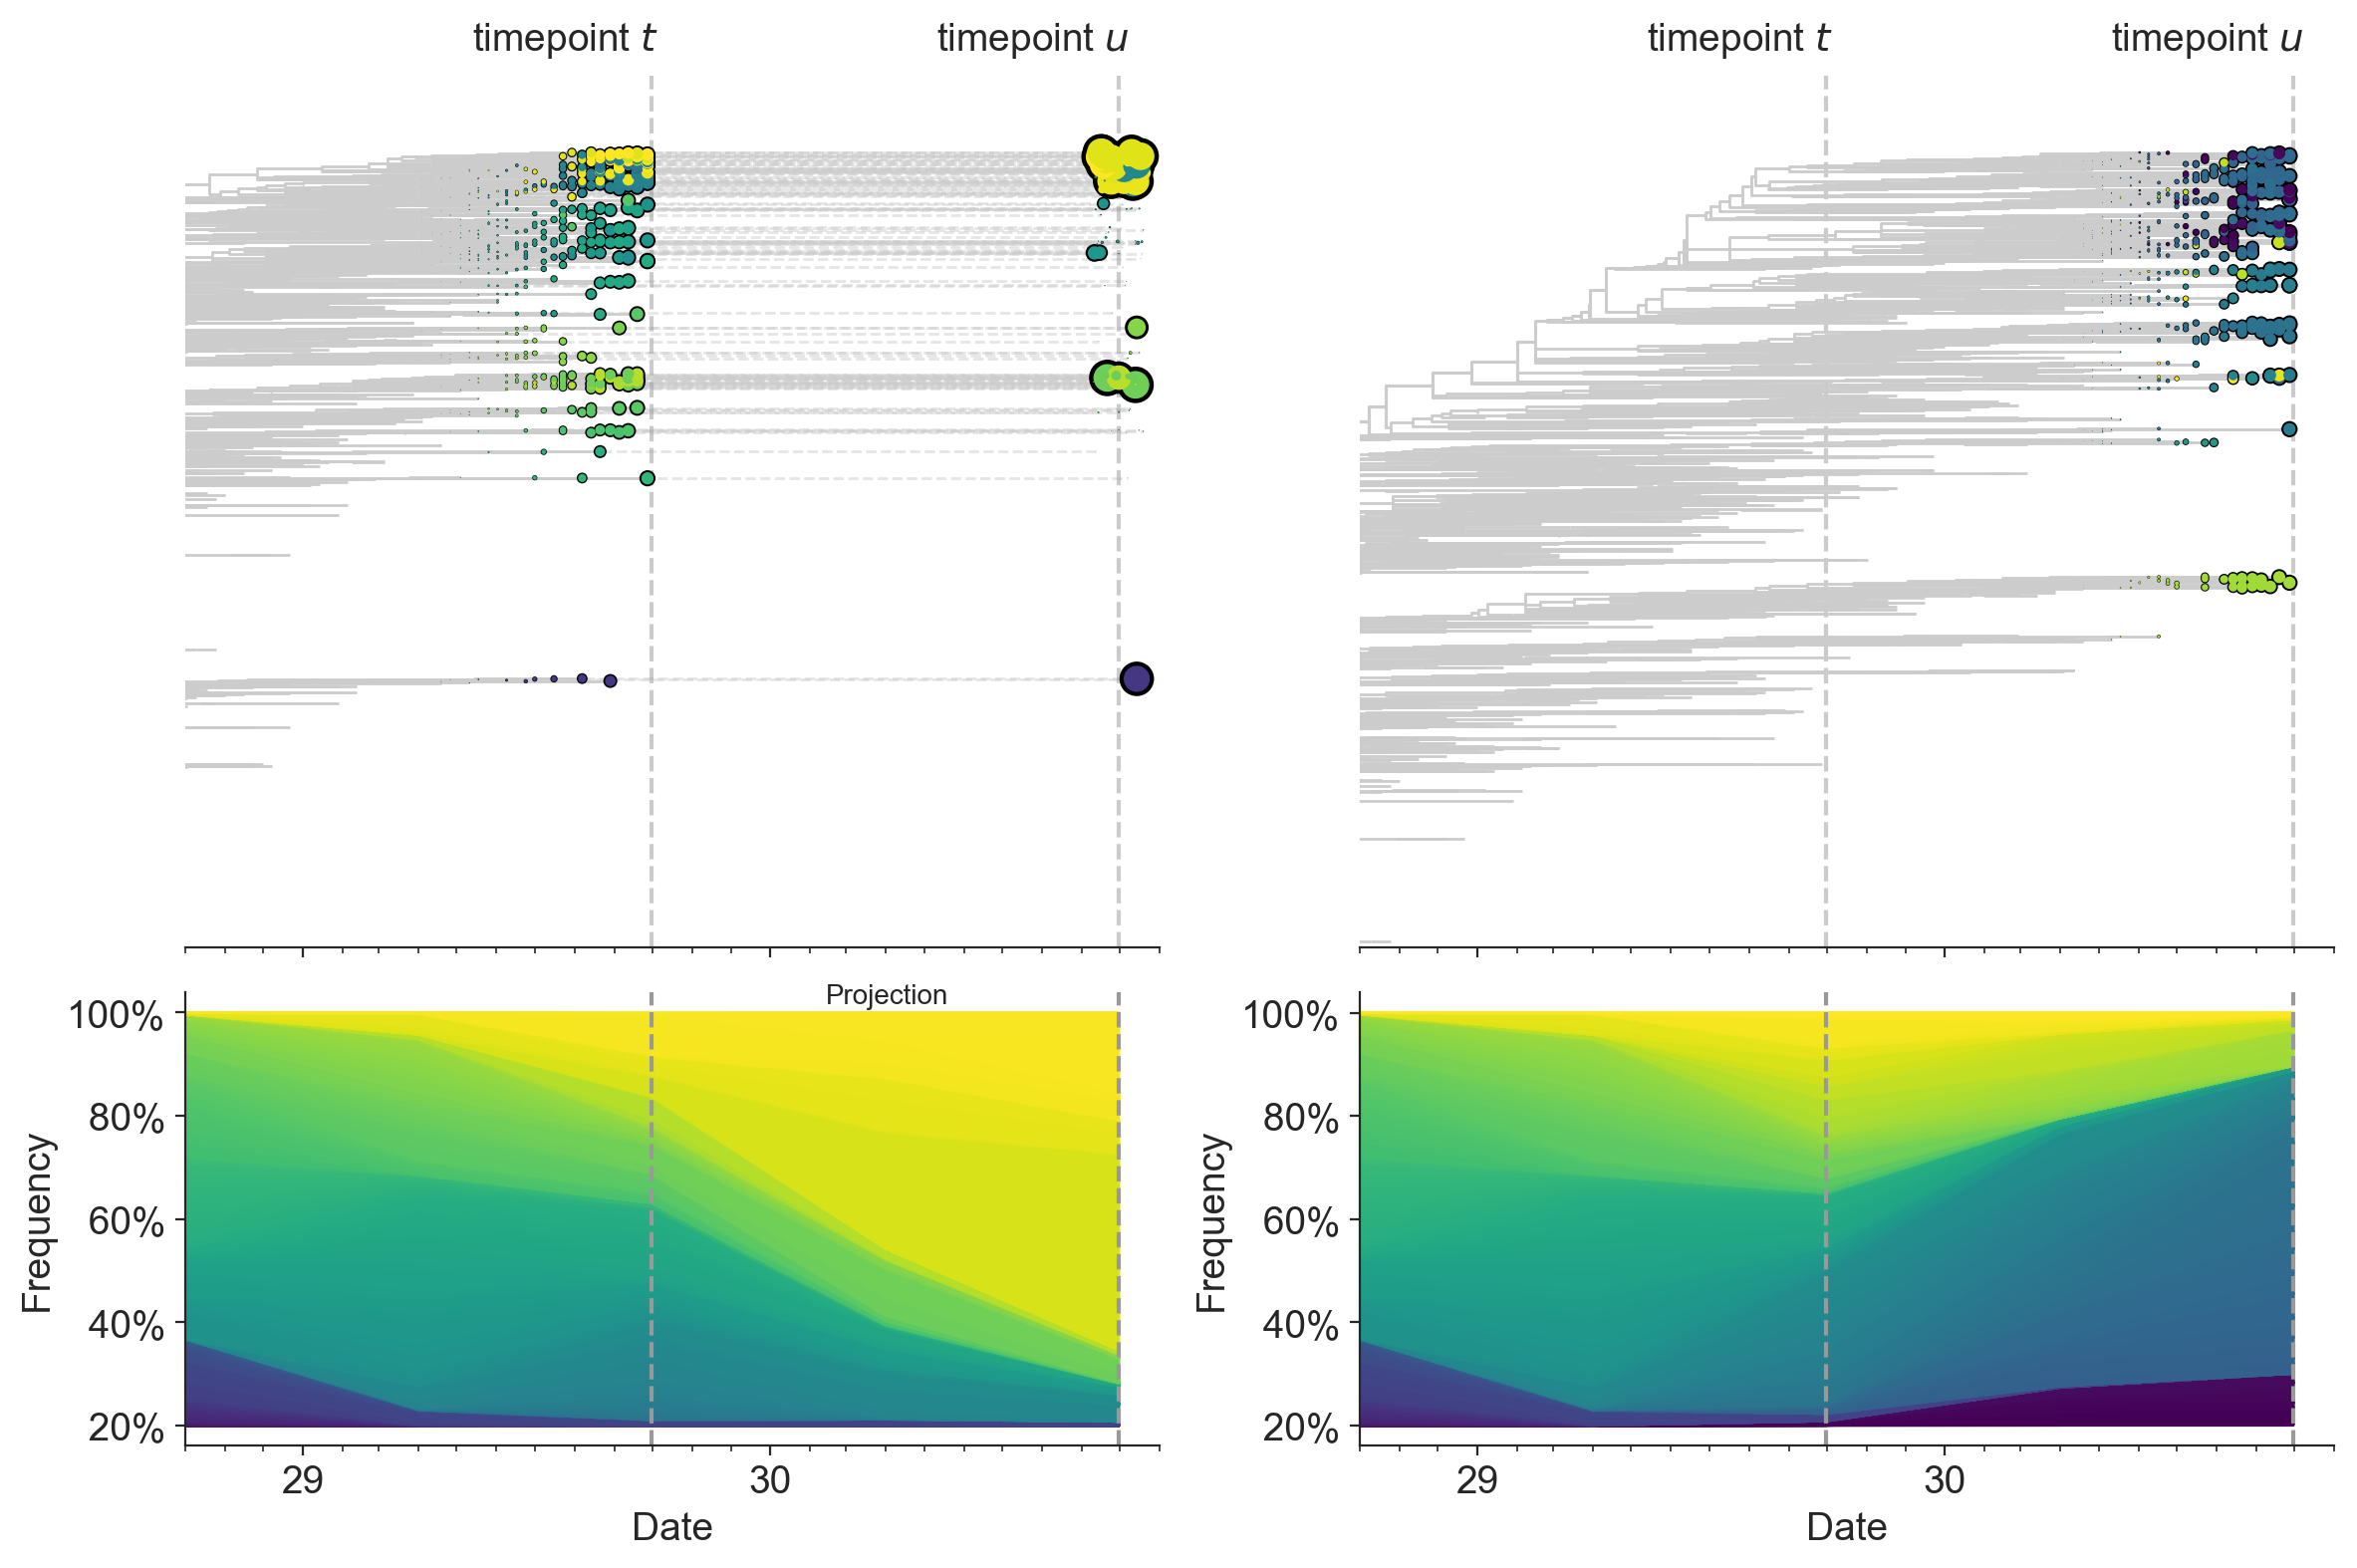

In [106]:
fig = plt.figure(figsize=(12, 8), facecolor='w')
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 0.5], width_ratios=[1, 1], hspace=0.25, wspace=0.1)

# Tree plot for timepoint t

tree_ax = fig.add_subplot(gs[0])    
tree_ax, colorbar_ax = plot_tree_by_datetime(
    tree_for_t,
    color_by_trait="rank",
    size_by_trait="frequency_at_t",
    ax=tree_ax,
    start_date=start_date,
    end_date=end_date,
    tip_size=tip_size,
    initial_branch_width=1,
    plot_projection_from_date=timepoint_t,
    plot_projection_to_date=timepoint_u,
    projection_attr="projected_frequency_at_u"
)
tree_ax.set_ylim(3500, 6900)

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter("%y")
months = mdates.MonthLocator()
tree_ax.xaxis.set_major_locator(years)
tree_ax.xaxis.set_major_formatter(years_fmt)
tree_ax.xaxis.set_minor_locator(months)
tree_ax.format_xdata = mdates.DateFormatter("%b %y")

tree_ax.text(0.39, 1.0, "timepoint $t$", 
             horizontalalignment='center',
             verticalalignment='center',
             transform=tree_ax.transAxes,
             fontdict={"fontsize": 14})
tree_ax.text(0.87, 1.0, "timepoint $u$", 
             horizontalalignment='center',
             verticalalignment='center',
             transform=tree_ax.transAxes,
             fontdict={"fontsize": 14})
tree_ax.axvline(x=timepoint_t, ymax=0.96, color="#999999", linestyle="--", alpha=0.5)
tree_ax.axvline(x=timepoint_u, ymax=0.96, color="#999999", linestyle="--", alpha=0.5)

# Frequency plot for timepoint t

frequency_ax = fig.add_subplot(gs[2])
baseline = np.zeros_like(pivots)
for strain, strain_df in rank_frequency_df_for_t.groupby(["rank", "strain"]):
    frequency_ax.fill_between(
        strain_df["ordinal_timepoint"].values,
        baseline, baseline + strain_df["frequency"].values,
        color=strain_df["color"].unique()[0]
    )
    baseline = baseline + strain_df["frequency"].values

frequency_ax.axvline(x=timepoint_t, color="#999999", linestyle="--")
frequency_ax.axvline(x=timepoint_u, color="#999999", linestyle="--")    

frequency_ax.text(
    0.72,
    0.99,
    "Projection",
    horizontalalignment="center",
    verticalalignment="center",
    transform=frequency_ax.transAxes,
    fontdict={"fontsize": 10}
)

frequency_ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
frequency_ax.set_ylabel("Frequency")
frequency_ax.set_xlabel("Date")

frequency_ax.set_xlim(start_date, end_date)

frequency_ax.xaxis.set_major_locator(years)
frequency_ax.xaxis.set_major_formatter(years_fmt)
frequency_ax.xaxis.set_minor_locator(months)
frequency_ax.format_xdata = mdates.DateFormatter("%b %y")

# Tree plot for timepoint u

tree_u_ax = fig.add_subplot(gs[1])    
tree_u_ax, colorbar_u_ax = plot_tree_by_datetime(
    tree_for_u,
    color_by_trait="rank",
    size_by_trait="frequency_at_u",
    ax=tree_u_ax,
    start_date=start_date,
    end_date=end_date,
    tip_size=tip_size,
    initial_branch_width=1
)
tree_u_ax.set_ylim(3500, 6900)

tree_u_ax.xaxis.set_major_locator(years)
tree_u_ax.xaxis.set_major_formatter(years_fmt)
tree_u_ax.xaxis.set_minor_locator(months)
tree_u_ax.format_xdata = mdates.DateFormatter("%b %y")

tree_u_ax.text(0.39, 1.0, "timepoint $t$", 
             horizontalalignment='center',
             verticalalignment='center',
             transform=tree_u_ax.transAxes,
             fontdict={"fontsize": 14})
tree_u_ax.text(0.87, 1.0, "timepoint $u$", 
             horizontalalignment='center',
             verticalalignment='center',
             transform=tree_u_ax.transAxes,
             fontdict={"fontsize": 14})
tree_u_ax.axvline(x=timepoint_t, ymax=0.96, color="#999999", linestyle="--", alpha=0.5)
tree_u_ax.axvline(x=timepoint_u, ymax=0.96, color="#999999", linestyle="--", alpha=0.5)

# Frequency plot for timepoint u

frequency_u_ax = fig.add_subplot(gs[3])
baseline_u = np.zeros_like(pivots[2:])
for strain, strain_df in rank_frequency_df_for_u.groupby(["rank", "strain"]):
    frequency_u_ax.fill_between(
        strain_df["ordinal_timepoint"].values[:projection_pivot_index + 1],
        baseline_u, baseline_u + strain_df["frequency"].values[:projection_pivot_index + 1],
        color=strain_df["color"].unique()[0]
    )
    baseline_u = baseline_u + strain_df["frequency"].values[:projection_pivot_index + 1]

frequency_u_ax.axvline(x=timepoint_t, color="#999999", linestyle="--")
frequency_u_ax.axvline(x=timepoint_u, color="#999999", linestyle="--")    

frequency_u_ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
frequency_u_ax.set_ylabel("Frequency")
frequency_u_ax.set_xlabel("Date")

frequency_u_ax.set_xlim(start_date, end_date)

frequency_u_ax.xaxis.set_major_locator(years)
frequency_u_ax.xaxis.set_major_formatter(years_fmt)
frequency_u_ax.xaxis.set_minor_locator(months)
frequency_u_ax.format_xdata = mdates.DateFormatter("%b %y")

fig.autofmt_xdate(rotation=0, ha="center")
gs.tight_layout(fig, h_pad=1.0)

plt.savefig("../manuscript/figures/distance-based-fitness-model.png")

In [ ]:
for tip in tree_for_u.find_clades(terminal=True):
    if "projected_frequency" in tip.attr:
        if tip.attr["projected_frequency"] > 0.05:
            tip.attr["projected_frequency"] = 0.05
    elif tip.attr["num_date"] > latest_sample_date_in_t:
        tip.attr["projected_frequency"] = 0.01
    else:
        tip.attr["projected_frequency"] = 0.0001

In [ ]:
for tip in tree_for_u.find_clades(terminal=True):
    if "weighted_distance_to_future" in tip.attr:
        tip.attr["inverse_weighted_distance_to_future"] = 1 / tip.attr["weighted_distance_to_future"]

In [ ]:
fig = plt.figure(figsize=(12, 12), facecolor='w')
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 0.33, 0.33], width_ratios=[1], hspace=0.25, wspace=0.1)

# Tree plot for timepoint u

tree_ax = fig.add_subplot(gs[0])    
tree_ax, colorbar_ax = plot_tree_by_datetime(
    tree_for_u,
    color_by_trait="rank",
    size_by_trait="inverse_weighted_distance_to_future",
    ax=tree_ax,
    start_date=start_date,
    end_date=end_date,
    tip_size=tip_size,
    initial_branch_width=1
)
tree_ax.set_ylim(350, 750)

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter("%y")
months = mdates.MonthLocator()
tree_ax.xaxis.set_major_locator(years)
tree_ax.xaxis.set_major_formatter(years_fmt)
tree_ax.xaxis.set_minor_locator(months)
tree_ax.format_xdata = mdates.DateFormatter("%b %y")

tree_ax.text(0.49, 1.0, "timepoint $t$", 
             horizontalalignment='center',
             verticalalignment='center',
             transform=tree_ax.transAxes,
             fontdict={"fontsize": 14})
tree_ax.text(0.97, 1.0, "timepoint $u$", 
             horizontalalignment='center',
             verticalalignment='center',
             transform=tree_ax.transAxes,
             fontdict={"fontsize": 14})
tree_ax.axvline(x=timepoint_t, ymax=0.96, color="#999999", linestyle="--")
tree_ax.axvline(x=timepoint_u, ymax=0.96, color="#999999", linestyle="--")

# Frequency plot for timepoint t

frequency_ax = fig.add_subplot(gs[1])
baseline = np.zeros_like(pivots)
for strain, strain_df in rank_frequency_df_for_t.groupby(["rank", "strain"]):
    frequency_ax.fill_between(
        strain_df["ordinal_timepoint"].values,
        baseline, baseline + strain_df["frequency"].values,
        color=strain_df["color"].unique()[0]
    )
    baseline = baseline + strain_df["frequency"].values

frequency_ax.axvline(x=timepoint_t, color="#999999", linestyle="--")
frequency_ax.axvline(x=timepoint_u, color="#999999", linestyle="--")    

frequency_ax.text(
    0.72,
    1.03,
    "Projection",
    horizontalalignment="center",
    verticalalignment="center",
    transform=frequency_ax.transAxes,
    fontdict={"fontsize": 10}
)

frequency_ax.set_yticks(frequency_steps)
frequency_ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in frequency_steps])
frequency_ax.set_ylabel("Frequency")
frequency_ax.set_xlabel("Date")

frequency_ax.set_xlim(start_date, end_date)
frequency_ax.set_ylim(0, 1)

frequency_ax.xaxis.set_major_locator(years)
frequency_ax.xaxis.set_major_formatter(years_fmt)
frequency_ax.xaxis.set_minor_locator(months)
frequency_ax.format_xdata = mdates.DateFormatter("%b %y")

# Frequency plot for timepoint u

frequency_u_ax = fig.add_subplot(gs[2])
baseline_u = np.zeros_like(pivots[2:])
for strain, strain_df in rank_frequency_df_for_u.groupby(["rank", "strain"]):
    frequency_u_ax.fill_between(
        strain_df["ordinal_timepoint"].values[:projection_pivot_index + 1],
        baseline_u, baseline_u + strain_df["frequency"].values[:projection_pivot_index + 1],
        color=strain_df["color"].unique()[0]
    )
    baseline_u = baseline_u + strain_df["frequency"].values[:projection_pivot_index + 1]

frequency_u_ax.axvline(x=timepoint_t, color="#999999", linestyle="--")
frequency_u_ax.axvline(x=timepoint_u, color="#999999", linestyle="--")    

frequency_u_ax.text(
    0.72,
    1.03,
    "Observed",
    horizontalalignment="center",
    verticalalignment="center",
    transform=frequency_u_ax.transAxes,
    fontdict={"fontsize": 10}
)

frequency_u_ax.set_yticks(frequency_steps)
frequency_u_ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in frequency_steps])
frequency_u_ax.set_ylabel("Frequency")
frequency_u_ax.set_xlabel("Date")

frequency_u_ax.set_xlim(start_date, end_date)
frequency_u_ax.set_ylim(0, 1)

frequency_u_ax.xaxis.set_major_locator(years)
frequency_u_ax.xaxis.set_major_formatter(years_fmt)
frequency_u_ax.xaxis.set_minor_locator(months)
frequency_u_ax.format_xdata = mdates.DateFormatter("%b %y")

fig.autofmt_xdate(rotation=0, ha="center")
gs.tight_layout(fig, h_pad=1.0)

#plt.savefig("../manuscript/figures/distance-based-fitness-model.png")

In [ ]:
fig = plt.figure(figsize=(8, 10), facecolor='w')
gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1, 0.5, 0.5], width_ratios=[1], hspace=0.5, wspace=0.1)

# Tree plot for timepoint t

tree_ax = fig.add_subplot(gs[0])    
tree_ax, colorbar_ax = plot_tree_by_datetime(
    tree_for_t,
    color_by_trait="rank",
    size_by_trait="projected_frequency",
    ax=tree_ax,
    start_date=start_date,
    end_date=end_date,
    tip_size=tip_size,
    initial_branch_width=1
)
tree_ax.set_ylim(400, 750)

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter("%y")
months = mdates.MonthLocator()
tree_ax.xaxis.set_major_locator(years)
tree_ax.xaxis.set_major_formatter(years_fmt)
tree_ax.xaxis.set_minor_locator(months)
tree_ax.format_xdata = mdates.DateFormatter("%b %y")

tree_ax.text(0.49, 1.0, "timepoint $t$", 
             horizontalalignment='center',
             verticalalignment='center',
             transform=tree_ax.transAxes,
             fontdict={"fontsize": 14})
tree_ax.text(0.97, 1.0, "timepoint $u$", 
             horizontalalignment='center',
             verticalalignment='center',
             transform=tree_ax.transAxes,
             fontdict={"fontsize": 14})
tree_ax.axvline(x=timepoint_t, ymax=0.96, color="#999999", linestyle="--")
tree_ax.axvline(x=timepoint_u, ymax=0.96, color="#999999", linestyle="--")

# Tree plot for timepoint u

tree_u_ax = fig.add_subplot(gs[1])    
tree_u_ax, colorbar_u_ax = plot_tree_by_datetime(
    tree_for_u,
    color_by_trait="rank",
    ax=tree_u_ax,
    start_date=start_date,
    end_date=end_date,
    tip_size=tip_size,
    initial_branch_width=1
)
tree_u_ax.set_ylim(300, 750)

tree_u_ax.xaxis.set_major_locator(years)
tree_u_ax.xaxis.set_major_formatter(years_fmt)
tree_u_ax.xaxis.set_minor_locator(months)
tree_u_ax.format_xdata = mdates.DateFormatter("%b %y")

tree_u_ax.text(0.49, 1.0, "timepoint $t$", 
             horizontalalignment='center',
             verticalalignment='center',
             transform=tree_u_ax.transAxes,
             fontdict={"fontsize": 14})
tree_u_ax.text(0.97, 1.0, "timepoint $u$", 
             horizontalalignment='center',
             verticalalignment='center',
             transform=tree_u_ax.transAxes,
             fontdict={"fontsize": 14})
tree_u_ax.axvline(x=timepoint_t, ymax=0.96, color="#999999", linestyle="--")
tree_u_ax.axvline(x=timepoint_u, ymax=0.96, color="#999999", linestyle="--")

# Frequency plot for timepoint t

frequency_ax = fig.add_subplot(gs[2])
baseline = np.zeros_like(pivots)
for strain, strain_df in rank_frequency_df_for_t.groupby(["rank", "strain"]):
    frequency_ax.fill_between(
        strain_df["ordinal_timepoint"].values,
        baseline, baseline + strain_df["frequency"].values,
        color=strain_df["color"].unique()[0]
    )
    baseline = baseline + strain_df["frequency"].values

frequency_ax.axvline(x=timepoint_t, color="#999999", linestyle="--")
frequency_ax.axvline(x=timepoint_u, color="#999999", linestyle="--")    

frequency_ax.text(
    0.72,
    1.0,
    "Projected",
    horizontalalignment="center",
    verticalalignment="center",
    transform=frequency_ax.transAxes,
    fontdict={"fontsize": 8}
)

frequency_ax.set_yticks(frequency_steps)
frequency_ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in frequency_steps])
frequency_ax.set_ylabel("Frequency")
frequency_ax.set_xlabel("Date")

frequency_ax.set_xlim(start_date, end_date)
frequency_ax.set_ylim(0, 1)

frequency_ax.xaxis.set_major_locator(years)
frequency_ax.xaxis.set_major_formatter(years_fmt)
frequency_ax.xaxis.set_minor_locator(months)
frequency_ax.format_xdata = mdates.DateFormatter("%b %y")

# Frequency plot for timepoint u

frequency_u_ax = fig.add_subplot(gs[3])
baseline_u = np.zeros_like(pivots[2:])
for strain, strain_df in rank_frequency_df_for_u.groupby(["rank", "strain"]):
    frequency_u_ax.fill_between(
        strain_df["ordinal_timepoint"].values[:projection_pivot_index + 1],
        baseline_u, baseline_u + strain_df["frequency"].values[:projection_pivot_index + 1],
        color=strain_df["color"].unique()[0]
    )
    baseline_u = baseline_u + strain_df["frequency"].values[:projection_pivot_index + 1]

frequency_u_ax.axvline(x=timepoint_t, color="#999999", linestyle="--")
frequency_u_ax.axvline(x=timepoint_u, color="#999999", linestyle="--")    

frequency_u_ax.text(
    0.72,
    1.0,
    "Observed",
    horizontalalignment="center",
    verticalalignment="center",
    transform=frequency_u_ax.transAxes,
    fontdict={"fontsize": 8}
)

frequency_u_ax.set_yticks(frequency_steps)
frequency_u_ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in frequency_steps])
frequency_u_ax.set_ylabel("Frequency")
frequency_u_ax.set_xlabel("Date")

frequency_u_ax.set_xlim(start_date, end_date)
frequency_u_ax.set_ylim(0, 1)

frequency_u_ax.xaxis.set_major_locator(years)
frequency_u_ax.xaxis.set_major_formatter(years_fmt)
frequency_u_ax.xaxis.set_minor_locator(months)
frequency_u_ax.format_xdata = mdates.DateFormatter("%b %y")

fig.autofmt_xdate(rotation=0, ha="center")
gs.tight_layout(fig, h_pad=1.0)

#plt.savefig("../manuscript/figures/distance-based-fitness-model.png")